In [2]:
from IPython.core.display import HTML, Markdown, display

import numpy.random as npr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.formula.api as smf

import ipywidgets as widgets

import requests
import zipfile
import os
import shutil
import nibabel
from scipy.stats import gamma

# Enable plots inside the Jupyter Notebook
%matplotlib inline

# MRI part 2: MRI data manipulation and regression

Authored by *Shannon Tubridy*, *Hillary Raab*, and *Todd Gureckis*  
Aspects borrowed from [Carsten Klein's Intro to fMRI analysis in Python](https://github.com/akcarsten/fMRI_data_analysis).



This lab continues the exercises from Lab1MRI-Pt1

### Review of Lab1MRI-Pt1

Last week we learned about the shape of structural and functional MRI data; we saw how to load MRI data into numpy arrays and how we index numpy arrays to extract data; and we conducted a correlation analysis to see which parts of the brain had a BOLD activation timecourse that was correlated with the timecourse of auditory stimulation presented to a participant.

<img src="./images/brain_basics.svg">

### Some key terms and concepts

- ***volume***: The three dimensional array covering the brain. Volumes are composed of ***voxels*** and each volume has one number (the MRI signal level) per voxel. Structural data has a single volume. Functional data has a volume for each timepoint of the experiment. 

- ***voxel***: A three-dimensional pixel and the basic unit of spatial measurement in MRI.

- ***slice***: A two-dimensional 'view' of the three-dimensional volume obtained by taking all of the elements in two of the dimensions for a fixed location in the third dimension. We can slice the three dimensional volume in three different ways. In the illustration above the orange slice is a single position in the X direction and all of the voxels in the Z (pointing up/down in our illustration) and Y (pointing left/right in the image) dimensions.

- ***TR***: The ***T***ime to ***R***epetition and the basic unit of time in functional MRI. A new measurement is made for each voxel in a volume every TR. TR length in fMRI is usually around 1-3 seconds.

- ***Timecourse*** or ***Timeseries***: a set of numbers representing a measurement (like BOLD activation) taken over time.

### Loading data.

First we start with importing the libraries for downloading, organizing and visualizing the data which comes from the SPM homepage (http://www.fil.ion.ucl.ac.uk/spm/). SPM is a popular Matlab Toolbox for analyzing fMRI brain imaging data and on their homepage some example datasets are provided.

(There are a number of data pre-processing steps involved in going from the MRI scanner to the data we're going to download here. These primarily have to do with accounting for distortions, artifacts, or other unwanted contaminations of the signal of interest. Although those preprocessing steps are crucial for the kinds of data examined in this notebook, they tend to be less related to questions about cognition and perception and so we'll jump ahead.)

Run the cell below to get all of the functional and structural data loaded into numpy arrays.

In [115]:
# Run this cell to load in the structural and functional data-- Depending on download speeds it could take a minute

# Define the URL of the data and download it using the Requests libary
url = 'http://www.fil.ion.ucl.ac.uk/spm/download/data/MoAEpilot/MoAEpilot.zip'
print('fetching remote data')
data = requests.get(url)
print('finished fetching remote data')

# Check if the targed folder for storing the data already exists. If not create it and save the zip file.
if os.path.exists('./fMRI_data/'):
    shutil.rmtree('./fMRI_data/')
if os.path.exists('./fMRI_data/') == False:
    try:
        os.makedirs('./fMRI_data/')
    except:
        print('./fMRI_data/' + ' doesn''t exist and/or it can''t be created')    
    
open('./fMRI_data/' + 'data.zip', 'wb').write(data.content)

# Un-zip the file
zip_ref = zipfile.ZipFile('./fMRI_data/' + 'data.zip', 'r')
zip_ref.extractall('./fMRI_data/')
zip_ref.close()


# Find all files in the structural data folder
data_path = './fMRI_data/' + 'sM00223/'
files = sorted(os.listdir(data_path))

for data_file in files:
    if data_file[-3:] == 'hdr' and data_file[0] == 's':
        structural_data = nibabel.load(data_path + data_file).get_data()    

        structural_data = np.rot90(structural_data.squeeze(), 1)
# -------------        
        
# Basic information about the data acquisition
x_size, y_size, z_size, n_volumes = 64, 64, 64, 98

data_path = './fMRI_data/' + '/fM00223/'
files = sorted(os.listdir(data_path))

data_all = []
for data_file in files:
    if data_file[-3:] == 'hdr' and data_file[0] == 'f':
        data = nibabel.load(data_path + data_file).get_data()        
        data_all.append(data.reshape(x_size, y_size, z_size))
        
functional_data = np.transpose(np.array(data_all),(1,2,3,0))
functional_data = np.rot90(functional_data)

fetching remote data
finished fetching remote data


### Checking the shape of the data

We have loaded our MRI data and we have stored them in numpy arrays. The structural data are contained in the array called `structural_data` and the functional_data are stored in the `functional_data` array.

We can check the number of dimensions and the number of elements in each dimension by using the shape() method.

First we'll look at the structural_data:

In [5]:
# store the shape in a variable
struct_shape = structural_data.shape
print(struct_shape)

# That shows us that there are three dimensions in the structural_data array, the first two dimensions 
# have 256 elements in them, and the third dimension has 54 elements.

# This means that our structural data is in a 3D box of size 256 x 256 x 54

# We can also access the size of the individual dimensions by indexing the struct_shape variable
# DONT FORGET THAT PYTHON STARTS INDEXING FROM 0!!!
print('The first element of struct_shape is: ')
print(struct_shape[0])


(256, 256, 54)
The first element of struct_shape is: 
256


<div class="alert alert-info" role="alert">
  <strong>Question 1</strong> <br>
   How many dimensions are in the functional data? Why is it different than the structural data? Get the shape of the "functional_data" variable and output it to a new variable. Use numpy indexing to get the size of the second dimension as stored in your output variable. Take a look at how we did the structural data dimension checking in the previous cell for some hints.
</div>

<div class="alert alert-warning" role="alert">
  <strong>Your Answer</strong> <br>
  Delete this text and put your answer here.
</div>

### Accessing data in the numpy arrays

In the last lab you also learned a little bit about accessing data stored in numpy arrays. Let's review some of those details now.

Our MRI data are in 3D and 4D data arrays but a numpy array can be any number of dimensions. In some ways you can think about a pandas data frame as being a two-dimensional array (rows and columns).

Let's take a look at a 1-dimensional array to remind ourselves of how to interact with the data.



In [6]:
# Make a numpy array of sequential numbers
# the range() function takes two numbers as arguments and returns a 
# list of numbers running from the first number to the second number minus 1
my_array = np.array(range(0,12))

# check the shape
print('the ''my_array'' shape is:')
print(my_array.shape)


the my_array shape is:
(12,)


If you look at the output of my_array.shape you'll see that it is 1-dimensional and there are 12 elements 
in the first dimension, as expected because we made the array to be that size.

You can access the values stored in the array by "indexing" the array, or telling python 
from where in the array you would like to retrieve the stored value(s)

The basic way of doing this in numpy is to use square brackets to tell the array which element(s) you want.

***IMPORTANT***
In python the elements in each dimension are indexed starting at ZERO

In [7]:
# let's take a look at the first element of my_array
first_element = my_array[0]
print('the first element is ' + str(first_element))

# how about the fifth element?
fifth_element = my_array[4]
print('the fifth element is ' + str(fifth_element))

# and now let's take all of the elements using the `:` indexer
all_elements = my_array[:]
print('all the elements in the array:')
print(all_elements)


the first element is 0
the fifth element is 4
all the elements in the array:
[ 0  1  2  3  4  5  6  7  8  9 10 11]


Take a look at what happened at the end of that last code cell where retrieved all the values.

We used my_array[:] and got back all of the numbers in the array.

The ':' indexer tells python that it should give back all the values along whichever dimension 
was indexed with ':'.

Make sure you take a minute to understand what we did in the previous couple of cells to access data in our data array.

Those examples were using a 1-dimensional array, but as you've already determined by using the `structural_data.shape` and `functional_data.shape` commands, our MRI data are stored in 3D and 4D arrays.

How do we access data in multi-dimensional arrays?

The logic is the same as before: we need to give the index, or the address, of locations we'd like data from.

Let's build towards that by moving on to a 2-dimensional array.

In [9]:
# use np.array to make a 2-dimensional array
my_2d_array = np.array([[1, 2, 3], [4, 5, 6]])

print('This is a 2d array:')
print(my_2d_array)

print('The shape of the 2d array:')
print(my_2d_array.shape)

This is a 2d array:
[[1 2 3]
 [4 5 6]]
The shape of the 2d array:
(2, 3)


<div class="alert alert-info" role="alert">
  <strong>Question 2</strong> <br>
   Take a look at what the 2d array looks like and at the reported shape that tells us the number of dimensions and the size of each of those dimensions. Can you figure out whether the first dimension of the 2d array refers to the rows or to the columns?
</div>

<div class="alert alert-warning" role="alert">
  <strong>Your Answer</strong> <br>
  Delete this text and put your answer here.
</div>

The question above previewed what's coming next. 

In order to get data from a multi-dimensional array we have to give a coordinate for each dimension. For the 2D array you might find it useful to think about $x$ and $y$ coordinates for the location of points in a grid.

In a 2D array the first dimension is the rows and the second dimension is the columns, and as you can see from `my_2d_array.shape` we have two rows and three columns.

To get the value from a particular location we simply need to give the $x,y$ (or row, column) coordinates or indexes that we want keeping two things in mind:

***Python indexes from zero***: this means that the first entry is the index position [0] and not [1]

***The 'origin', or zero point for a 2d array is the upper left entry***

In [10]:
# get the value from the first row and first column:
print(my_2d_array[0,0])

# take another look at the array so we can see that this is true:
print(my_2d_array)

# we can also store the index coordinate in a variable:
x_coordinate = 0
y_coordinate = 0
print(my_2d_array[x_coordinate, y_coordinate])


1
[[1 2 3]
 [4 5 6]]
1


### Slicing in a multi-dimensional array

Earlier in this notebook you saw how to get all of the elements from a 1-dimensional array using the ':' indexer

`my_array[:]`

We can also use this in a multi-dimensional array.

Let's get all of the values in the first row our 2d array:

In [12]:
print('The first row: ')
print(my_2d_array[0,:])

print('\n The whole array:')
print(my_2d_array)

The first row: 
[1 2 3]

 The whole array:
[[1 2 3]
 [4 5 6]]


<div class="alert alert-info" role="alert">
  <strong>Question 3</strong> <br>
   Take a look at how we used ':' indexing for our 2d array in the previous example. What do you think would happen if we used the ':' indexer for both the first and second dimensions of our 2d array?
</div>

<div class="alert alert-warning" role="alert">
  <strong>Your Answer</strong> <br>
  Delete this text and put your answer here.
</div>

### Accessing data from our MRI data arrays

Our MRI data are in 3D (structural) and 4D (functional) arrays, but the indexing works the same as with 1- and 2D arrays.

If we want to query data from a single voxel in a 3D array we need to give its' x,y, AND z (or dimensions one, two and three) coordinate and use those to index the numpy array.

For example, our structural data has three dimensions:

```
# set x, y, and z coordinate:
x_coord = 20
y_coord = 35
z_coord = 30

# use coordinates to get a value for one voxel
structural_data[x_coord, y_coord, z_coord]
```

What about the functional data? How do we index that?

<div class="alert alert-info" role="alert">
  <strong>Question 4</strong> <br>
   For this question we will use the 'functional_data' array that was created when we loaded the MRI data. Building on what you just read about indexing, can you get all of the data in the fourth dimension for a single x,y,z location in the 'functional_data'? Looking back at the schematic figure at the start of this notebook, what does the data you extracted represent?
</div>

<div class="alert alert-warning" role="alert">
  <strong>Your Answer</strong> <br>
  Delete this text and put your answer here.
</div>

### Slicing the 3D brain volumes

Last week we also saw that in order to view the MRI data as in image we need to take a "slice" from the 3D volume.

We did this by taking all of the voxels (elements) in two of the dimensions for a single location in the third dimension. This is illustrated in orange in the schematic figure.

Take a look at the code in the next cell at the line starting with `ax.imshow` and see if you can figure out what's going on with the structural_data array.

In that line we are taking all of the elements in the first two dimensions for a single position in the third dimension. The position for the third dimension is specified in the variable `slice`, and moving the slider is changing the value of the `slice` variable.

Give it a try.

In [13]:
@widgets.interact(slice=widgets.IntSlider(min=0, max=53, step=1, value=0))
def plot_struct(slice):
    #setup the figure:
    fig, ax = plt.subplots(1, 1, figsize=[10,10])
    
    # index the structural_data:
    ax.imshow(structural_data[:,:,slice],'gray')
    
    fig.subplots_adjust(wspace=0, hspace=0)
    plt.show()

interactive(children=(IntSlider(value=0, description='slice', max=53), Output()), _dom_classes=('widget-intera…

We can do something similar to view images of the functional data, but now we have to think about how to handle the fourth dimension.

The functional data can be thought of as a stack of 3D volumes. 

The stack of 3D volumes represents the data recorded during fMRI scanning, with one volume (and the BOLD signal for each of its' voxels) recorded every TR. The number of volumes in our stack is the number of timepoints in the experiment and is also the size of the fourth dimension in the `functional_data` array.

So if we want to plot the functional data as a 2D slice of the brain we need to choose one of the spatial dimensions to slice through and also a single timepoint for which we'd like to see that plane. Once we choose a single timepoint we have one 3D volume, and then we can choose one of the dimensions to slice through, just like the structural data.

Here is a version of the slider image we looked at before using the structural data, but now using the functional data. If you take a close look at the `ax.imshow` line in our plotting function you'll see that it's indexing the `functional_data` in the same way that we did the structural data above except we also have to specify a timepoint to plot.

In [14]:
@widgets.interact(slice=widgets.IntSlider(min=0, max=53, step=1, value=0))
def plot_functional(slice):
    # setup the figure:
    fig, ax = plt.subplots(1, 1, figsize=[10,10])
    
    # index the functional_data:
    ax.imshow(functional_data[:, :, slice, 3],'gray')
    
    fig.subplots_adjust(wspace=0, hspace=0)
    plt.title('Functional data')
    plt.show()

interactive(children=(IntSlider(value=0, description='slice', max=53), Output()), _dom_classes=('widget-intera…

<div class="alert alert-info" role="alert">
  <strong>Question 5</strong> <br>
   Take a look at how we are indexing the 'functional_data' array in the plotting function we just used. Can you tell which timepoint we are using to plot?
</div>

<div class="alert alert-warning" role="alert">
  <strong>Your Answer</strong> <br>
  Delete this text and put your answer here.
</div>

### Analyzing BOLD activation timeseries

We have looked at 2D slices of our functional data and we have extracted the timeseries for a single voxel (Question 4).

The MRI data we are looking at was collected while the participant was listening to alternative periods of silence and speech.

Let's take a look at the timeseries of activation for 500 voxels to see if we can get some insights into what this person's brain was doing.

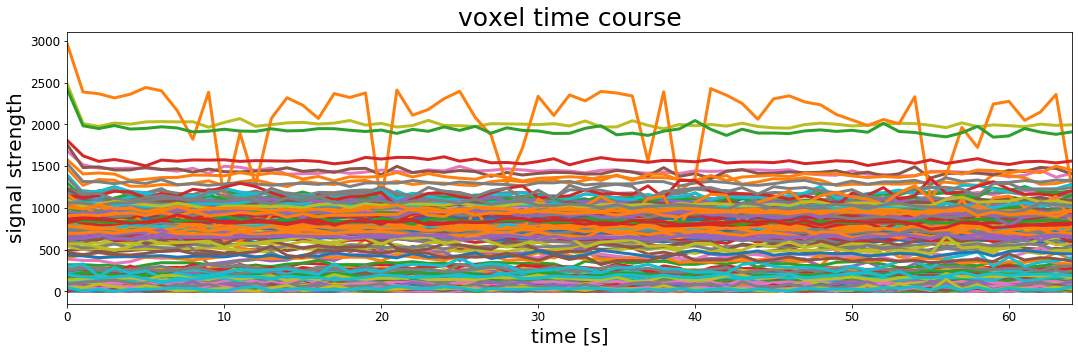

In [15]:
# Create an empty plot with defined aspect ratio
fig, ax = plt.subplots(1, 1, figsize=[18, 5])

n_voxels_to_plot=500

# do a loop, once for every number between 0 and the number of voxels to plot
for _ in range(0, n_voxels_to_plot):
    
    # set random x,y,z coordinates by asking numpy to give us random numbers between 0 and 64
    # using np.random.randint()
    x_coord = np.random.randint(64)
    y_coord = np.random.randint(64)
    z_coord = np.random.randint(64)
    
    # get all of the timepoints for the current x,y,z coordinate and plot it
    ax.plot(functional_data[x_coord, y_coord, z_coord, :], lw=3)

ax.set_xlim([0, functional_data.shape[0]])
ax.set_xlabel('time [s]', fontsize=20)
ax.set_ylabel('signal strength', fontsize=20)
ax.set_title('voxel time course', fontsize=25)
ax.tick_params(labelsize=12)

plt.show()

This is the timecourse of BOLD signal for 500 voxels in our participant's brain. 

It looks kind of interesting but it doesn't give us much insight into how this person's brain was processing the auditory stimulus they were hearing during the experiment. 

One thing to note here, however, is that even with the relatively small number of voxels plotted above we can see that the activation timecourses differ in their average level of signal as well as their dynamics over time. 

This might not be surprising given that we know that not every part of the brain does the same thing, but it also previews a difference between what we did before with correlation and regression and how we're going to use it to analyze MRI data.

Previously we looked at whether two sets of numbers were correlated, or whether the values of one set of numbers moved in a predictable way relative to another set of numbers like in the sleepy and grumpy dataset. In those analyses we wanted to know whether there was a relationship between the two sets of numbers and we did this by assessing whether the numbers covaried.

For fMRI data we can use the same correlation or regression calculations, but now we are going to run many analyses (one for each voxel in our data) with the hopes of understanding which, if any, parts of the brain are related to the set of predictor values we are testing.

### Voxel timecourses and correlation

One of the most direct ways to understand fMRI data is to see whether different voxel timecourses correlate with some predictor variable of interest. We will unpack this throughout the rest of this MRI lab, but it should seem familiar: we have already seen examples of computing the correlation between two sets of numbers to understand whether there is a relationship between them. 

We also saw that in some ways regression operates in a related way where we'd like to find the closest match between predictor variable (sleep) and the values of some measured outcomes (grumpiness). 

### Relating brain data to the experimental protocol

The general approach to analyzing fMRI data builds on this approach by measuring whether there is a relationship between a predictor variable representing the cognitive or perceptual context over the coures of the experiment and any individual voxel timecourses of BOLD activation. 

If the predictor variable composed from the cognitive or perceptual design of the experiment can ***explain*** the variation in a voxel timeseries we would have some evidence on which to make inferences about what that part of the brain is doing.

The data we have been playing with in this notebook come from an experiment in which the participant alternated between listening to spoken words or hearing nothing.

So let's think: 

How would you imagine the brain signal response to look in a study like this? If a part of the brain was involved in processing spoken verbal stimuli what would we predict its' activation to look?

For now, lets keep things simple and just assume that without a stimulus (the playing of "bi-syllabic words") the signal in a sound-sensitive part of the brain is at a baseline level and during the auditory stimulation the signal goes up.

Let's make a simple "model" of what that would look like. 

In order to do it we will need some details about the experiment and MRI scanning. We'll come back to this later, but for now let's use them to make a timecourse of what we think it would like for a brain region to be "active" during auditory stimulation and "silent" during rest (no stimulation).

In [123]:
# These are the main parameters of the fMRI scan and experimental design
block_design    = ['rest', 'stim']
block_size      = 6
block_RT        = 7
block_total     = 16
block_length    = block_size*block_RT

acq_num         = block_size*block_total
data_time       = block_length*block_total
data_time_vol   = np.arange(acq_num)*block_RT

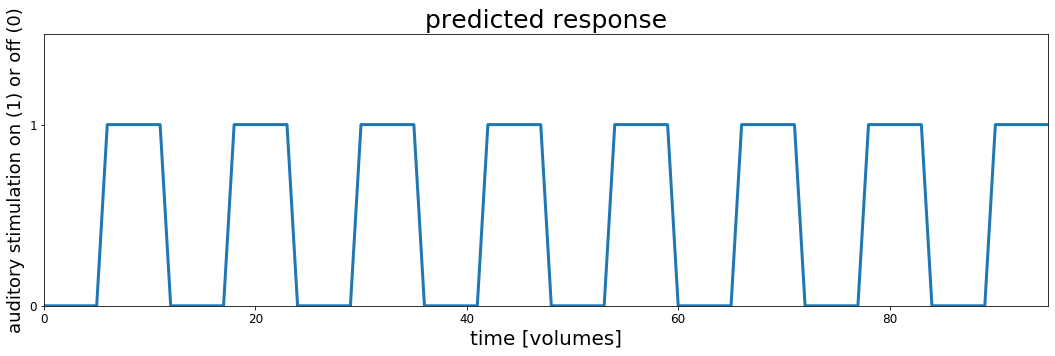

In [124]:
# we can use the experimental parameters to make timecourse plot showing when the auditory stimulation happened
rest     = np.zeros(block_size)
stim     = np.ones(block_size)
block    = np.concatenate((rest, stim), axis=0)
predicted_response = np.tile(block, int(block_total/2))

fig, ax = plt.subplots(1, 1, figsize=[18, 5])

ax.plot(predicted_response, lw=3)
ax.set_xlim(0, acq_num-1)
ax.set_ylim(0, 1.5)
ax.set_title('predicted response', fontsize=25)
ax.set_yticks([0,1])
ax.set_xlabel('time [volumes]', fontsize=20)
ax.set_ylabel('auditory stimulation on (1) or off (0)', fontsize=18)
ax.tick_params(labelsize=12)
ax.tick_params(labelsize=12)

# fig.subplots_adjust(wspace=0, hspace=0.5)
plt.show()

Let's take a moment to look at this plot. This represents the timecourse of auditory stimulation in the experiment. The x-axis represents time and the y-axis shows whether sound was on ($y=1$) or off ($y=0$).

This is the set of values, one for each point in time that we will use to try to understand the fMRI data collected in this experiment. We will search through the brain, looking to see whether any voxel timeseries are well explained by this predicted response and if they are we might conclude that they are involved in hearing.

### Correlating the stimulus timecourse with the brain

Let's see what happens if we try correlating the auditory stimulation timecourse with each of the voxel BOLD timecourses.

First we need to do some bookkeeping and turn our 4D functional data into a 2D array for ease of use with some stats functions.

In [22]:
# Make the 4D data 2D (nvox X ntimepoints)
all_data_2d = np.reshape(functional_data,(functional_data.shape[0]*functional_data.shape[1]*functional_data.shape[2],functional_data.shape[3]))

Now we will loop over our array of voxel timeseries and for each one we will compute the correlation with the auditory stimulation timecourse.

Note that this looping procedure is somewhat inefficient and the next cell may take up to 30 seconds to run

In [23]:
# DO THE CORRELATION OF EACH VOXEL BOLD TIMECOURSE WITH THE PREDICTOR TIMECOURSE

# initialize some empty variables for storing our 
r_values = []
p_values = []

# loop over every timeseries in our data
print('doing lots of correlation calculations...')
for idx, val in enumerate(range(0,all_data_2d.shape[0])):
    r,p = stats.pearsonr(predicted_response, all_data_2d[idx,:])
    r_values.append(r)
    p_values.append(p)
print('finished with correlations')
    
# The r and p values are stored in 1d arrays (n voxels). Reshape back into a 3D array for visualization
nx = functional_data.shape[0]
ny = functional_data.shape[1]
nz = functional_data.shape[2]
r_values_vol = np.reshape(r_values, (nx, ny, nz))
p_values_vol = np.reshape(p_values, (nx, ny, nz))

doing lots of correlation calculations
finished with correlations


### Visualizing results

Our results are stored in the variables `r_values_vol` and `p_values_vol`.

<div class="alert alert-info" role="alert">
  <strong>Question 6</strong> <br>
    Check the shape of the 'r_values_vol' array. How do the dimensions compare to the shape of the 'functional_data' array? What's the same and what's different? Why is there this difference?
</div>

<div class="alert alert-warning" role="alert">
  <strong>Your Answer</strong> <br>
  Delete this text and put your answer here.
</div>

Now that we have the r (and associated p) value that tells us how much each voxel timeseries correlates with the auditory stimulation predictor timecourse we can look and see whether there are any parts of the brain that respond in the way we predicted.

To do this we will look at our array of computed $r$ values and find the maximum value using a convenient numpy method called `argmax`.

We use argmax on a data array like this: `my_array.argmax()`

Doing that will give us the index position where the maximum value appears.

This next cell will find that voxel and plot its' timeseries overlaid on our predictor timeseries.

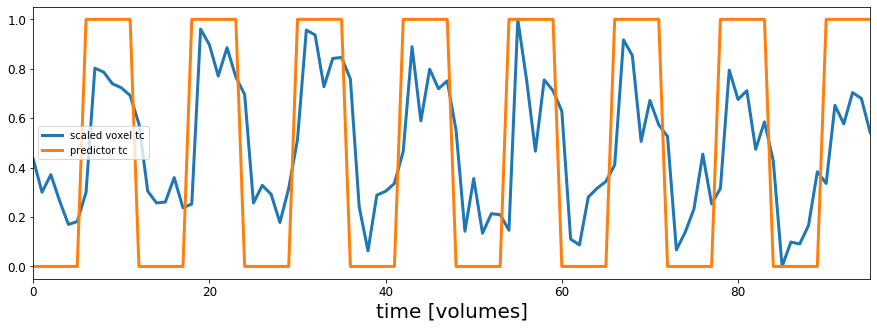

In [24]:
# Find the index position of the maximum value in the r_value array
max_idx = r_values_vol.argmax()
# argmax returns the linear index, so turn into x/y/z index values
max_x, max_y, max_z = np.unravel_index(max_idx, r_values_vol.shape)

# use the max_x, _y, and _z indices to get the timecourse of the best correlated voxel
max_corr_timecourse = functional_data[max_x, max_y,max_z,:]

# Define the min-max scaling function to put the voxel timecourse and predictor timecourse on the same slace
def scale(data):
    return (data - data.min()) / (data.max() - data.min())

# Create the plots
fig, ax = plt.subplots(1,1,figsize=(15, 5))
ax.plot(scale(max_corr_timecourse), lw=3, label='scaled voxel tc')
ax.plot(predicted_response, lw=3, label='predictor tc')
ax.set_xlim(0, acq_num-1)
ax.set_xlabel('time [volumes]', fontsize=20)
ax.tick_params(labelsize=12)
ax.legend()
plt.show()

Hey that looks pretty good!

OK now we can see that the timecourse for this voxel looks similar to our assumed response if a voxel was to respond to sound like in the predicted timecourse. 

But how are voxels that correlate with our idealized timecourse distributed across the brain? Lets check.<br>

We will make a figure that has three panels:

One will show the image of the brain like before, the next will show an image where each voxel is colored according to the pearsons $r$ value calculated in the correlation above, and the third image will show a "thresholded" map of the correlation values, showing only those voxels whose correlation value is significant according to a chosen threshold (i.e., $p <$ chosen_treshold)

To do this we will first take a slice of our r and p volumes because we can't look at the 3D array all at once.

Taking the 2D slice of our 3D `r_values_vol` and `p_values_vol` arrays is just like doing it for the brain views we did at the beginning of this notebook:

`r_values_slice = r_values_vol[:,:,slice]`

Then we can either plot the slice of r_values directly, which will produce an image where each voxel has a color indicating the magnitude of the r value for that voxel, or we can ***theshold*** our map, and only color those voxels whose correlation was stronger than a cutoff level.

[]

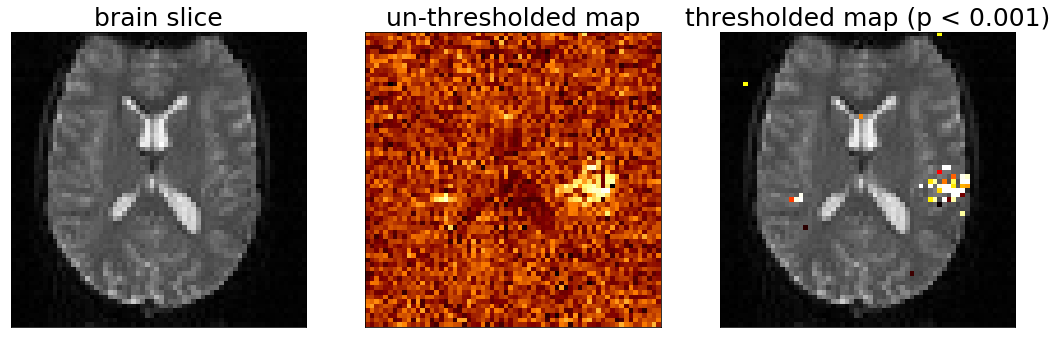

In [25]:
# make thresholded versions of the r and p volumes
# use numpy to set voxels that don't meet the cutoff to "not a number" (nan)
p_val_cutoff = .001
p_thresholded = p_values_vol.copy()
p_thresholded[p_thresholded > p_val_cutoff] = np.nan

r_val_cutoff = .01
r_thresholded = r_values_vol.copy()
r_thresholded[abs(r_thresholded) < r_val_cutoff] = np.nan

# Ok now lets visualize all the maps
fig, ax = plt.subplots(1,3,figsize=(18, 6))

# we will plot views through our data using the max_z index we found above
slice_to_plot=max_z
slice_to_plot = 36

# First plot a view of the functional data
ax[0].imshow(functional_data[:,:,slice_to_plot,10], cmap='gray')
ax[0].set_title('brain slice', fontsize=25)
ax[0].set_xticks([])
ax[0].set_yticks([])

# Now let's look at the correlation values with no threshold
ax[1].imshow(r_values_vol[:,:,slice_to_plot],  cmap='afmhot')
ax[1].set_title('un-thresholded map', fontsize=25)
ax[1].set_xticks([])
ax[1].set_yticks([])

# Plot a thresholded map, coloring only those voxels that are signficant at p < p_val_cutoff
ax[2].imshow(functional_data[:,:,slice_to_plot,10], cmap='gray')
ax[2].imshow(p_thresholded[:,:,slice_to_plot], cmap='hot_r')
ax[2].set_title('thresholded map (p < ' + str(p_val_cutoff) + ')', fontsize=25)
ax[2].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])

Look at that, we made some brain maps! 

And it looks like there is some structure to the data. 

The data we're looking at is oriented so that the front of the participant head is pointing up and the left/right of their head is in the left/right of the figure.

The un-thresholded map in the middle is showing correlation value for each voxel.

The thresholded map is made by finding the voxels in the untresholded map whose correlation values are significant in the sense that the $p$ value was less than or equal to our threshold.

The analysis we did was to measure whether any voxels correlated with our the predicted response (the timeseries of auditory activation) and it seems like the voxels with the highest values are on the side of the head, possibly near the ears. Very cool!

But you also might notice that there are other voxels that are colored here. What do they mean? Are they real or are they just due to random chance?

Let's play with the significance threshold for plotting brain maps.

This next cell will define a convenience function to wrap up the thresholded plotting code we used to make the figure above, except we will adjust the ***p*** value associated with the calculated correlation coeffecients ($r$).

The ***p*** value corresponds to the "signifiance" of a single correlation test and represents the chances of observing an $r$ value that high by chance. 

This is the value that is used for the classic $p < 0.05$ threshold for deciding whether a statistical result is significant.

In the next cell we can use the slider to change the p value threshold, and only those voxels whose correlation had a p value ***less than*** the slider value will be plotted.

The voxels will be colored according to their $p$ value, with more significant voxels (lower $p$ values) plotted in brighter colors and the most significant voxels will be colored white (white < yellow < red).

In [26]:
@widgets.interact(p_val_cutoff=widgets.FloatSlider(min=.0000000000001, max=.2, step=.001, value=0.1, height=40))
def plot_thresholded_brains(p_val_cutoff):
    assert p_val_cutoff >= 0 and p_val_cutoff <= 1,'p_reshold should be between 0 and 1'
    
    # make thresholded versions of the r and p volumes
    # use numpy to set voxels that don't meet the cutoff to "not a number" (nan)
#     p_val_cutoff = .001
    p_thresholded = p_values_vol.copy()
    p_thresholded[p_thresholded > p_val_cutoff] = np.nan

    r_val_cutoff = .01
    r_thresholded = r_values_vol.copy()
    r_thresholded[abs(r_thresholded) < r_val_cutoff] = np.nan

    # Ok now lets visualize all the maps
    fig, ax = plt.subplots(1,3,figsize=(18, 6))

    # we will plot views through our data using the max_z index we found above
    slice_to_plot=max_z
    slice_to_plot = 36

    # First plot a view of the functional data
    ax[0].imshow(functional_data[:,:,slice_to_plot,10], cmap='gray')
    ax[0].set_title('brain slice', fontsize=25)
    ax[0].set_xticks([])
    ax[0].set_yticks([])

    # Now let's look at the correlation values with no threshold
    ax[1].imshow(r_values_vol[:,:,slice_to_plot],  cmap='afmhot')
    ax[1].set_title('un-thresholded map', fontsize=25)
    ax[1].set_xticks([])
    ax[1].set_yticks([])

    # Plot a thresholded map, coloring only those voxels that are signficant at p < p_val_cutoff
    ax[2].imshow(functional_data[:,:,slice_to_plot,10], cmap='gray')
    ax[2].imshow(p_thresholded[:,:,slice_to_plot], cmap='hot_r')
    ax[2].set_title('thresholded map (p < ' + str(p_val_cutoff) + ')', fontsize=25)
    ax[2].set_yticks([])
    ax[2].set_xticks([])
    ax[2].set_yticks([])

interactive(children=(FloatSlider(value=0.1, description='p_val_cutoff', max=0.2, min=1e-13, step=0.001), Outp…

<div class="alert alert-info" role="alert">
  <strong>Question 7</strong> <br>
    Play with the slider, trying out different significance thresholds. What happens if you make the threshold very lenient (higher p_val_cutoff)? What happens if you make it very strict? Pay particular attention to the spatial distribution of the voxels in the thresholded map. What do you notice about the spatial arrangement of the voxels who have the most significant correlation with the predictor timecourse? Where are those voxels compared to each other? What about the voxels that are significant at p < .05? Do you notice anything funny about where some of these voxels are relative to the underlying gray brain image?
</div>

<div class="alert alert-warning" role="alert">
  <strong>Your Answer</strong> <br>
  Delete this text and put your answer here.
</div>

### Multiple comparison corrections with Bonferroni

The traditional p < .05 threshold indicates that we could expect the statistical result that is significant at p < .05 to occur by chance less than 5% of the time. If we observe a correlation that has a significance value of p < .05 we would reject the null hypothesis that the two sets of values are unrelated with the caveat that we might be wrong up to 5% of the time.

This works pretty well when we run a single test like the sleepy and grumpy example.

But in our MRI analysis we have run ***many*** individual correlations, each with their own r and p value.

Adding up the 5% chance of being wrong on each test across thousands of voxels means that at p < .05 we almost certainly are finding voxel correlations that are just due to chance.

One approach to the problem of identifying significant results when running multiple statistica tests is the *Bonferroni correction*.

The Bonferroni correction adjusts the p value (or the alpha level corresponding to the number of Type I errors we will accept in our results) to take account of the number of tests being run:

$p_{bonferroni} = \frac{\alpha}{m}$

$\alpha$: desired overall false positive rate

$m$: the number of comparisons (e.g., the number of voxels)

To compute the appropriate p level using the Bonferroni correction we divide our desired false positive rate (e.g., $.05$) by the number of separate tests being conducted. In our fMRI data the number of tests is equal to the number of voxels since we are running one correlation for every voxel timeseries.


<div class="alert alert-info" role="alert">
  <strong>Question 8</strong> <br>
    In order to do an appropriate Bonferroni correction to the significance level of our MRI data we need to know how many voxels there are in our functional_data. Using the shape() function that you learned about in this notebook, calculate the number of voxels in the functional data (hint: the volume of a 3D box is the length x width x height). Then, calculate the Bonferroni corrected p value if our desired alpha level is .05.
</div>

<div class="alert alert-warning" role="alert">
  <strong>Your Answer</strong> <br>
  Delete this text and put your answer here.
</div>

If you want to see which voxels throughout the brain are significant at a particular p value you can play with the next cell. First set the p value you want using the `p_val_cutoff` variable and then run the cell. The slider will move you up and down through the brain and you can see the voxels with correlation p < p_val_cutoff overlaid with color.

In [28]:
p_val_cutoff = .05
p_thresholded = p_values_vol.copy()
p_thresholded[p_thresholded > p_val_cutoff] = np.nan


@widgets.interact(slice=widgets.IntSlider(min=0, max=53, step=1, value=0))
def plot_thresholded_slices(slice):

    fig, ax = plt.subplots(1, 1, figsize=[10,10])
    ax.imshow(functional_data[:,:,slice,10], cmap='gray')
    ax.imshow(p_thresholded[:,:,slice], cmap='afmhot_r')
    ax.set_title('thresholded map (p < ' + str(p_val_cutoff) + ')', fontsize=25)
    fig.subplots_adjust(wspace=0, hspace=0)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

interactive(children=(IntSlider(value=0, description='slice', max=53), Output()), _dom_classes=('widget-intera…

The Bonferroni correction is a valid statistical procedure, but it is often overly strict and can make it difficult to observe interesting true effects.

Another approach to dealing with the problem of multiple comparisons is to reduce the number of comparisons!

That sounds kind of simple and when stated like that it is, but this approach is where knowledge of the domain you are working in becomes crucial. It is often the case that there are things that are measured (or could be measured) that we don't really think are relevant.

In the sleepy and grumpy example this was done implicitly by the construction of our 'experiment': we went into the question with pre-existing knowledge that sleepiness might be related to grumpiness and so we focused on a single statistical test.

In theory we could have tested any number of measurements about dad and what makes him grumpy and run correlations between every aspect of the world and dad's grumpiness. But using prior knowledge, we were able to focus on a reasonable set of things to correlate with each other and we didn't consider whether, for example, the number of dogs in Golden Gate Park in Calfornia between 10am and 11am each morning is correlated with the grumpiness of dad in NYC.

We can use a similar kind of focused testing in thinking about our MRI data. You might not think you're an expert on fMRI right now but you probably know enough about the brain to step in the right direction.

Take another look at one of the thresholded correlation maps you plotted above. Now think back to when you calculated the number of voxels in the functional data.

One thing you might have already noticed is that 3D box that contains each volume of the functional data includes voxels that are not inside the brain. This is what shows up as black when we plot slices of the structural and functional data.

The MRI scanner doesn't know what it's making an image of. It just measures a 3D grid of voxels and saves those numbers. It's up to us as researchers to focus on the interesting parts of the image.


So just like we can restrict our analysis of dad's grumpiness and not consider things that are almost certainly unrelated to what we're analyzing, we can do the same with the brain by not even looking at voxels that aren't inside the brain. Our question with these fMRI data is how the person's brain responded to auditory stimulation so it doesn't really make sense to look outside of the person's brain.



### "Masking" and MRI analysis

In order to restrict our MRI analysis to voxels of interest (like voxels that are actually in the brain) we need a way of identifying those voxels.

In MRI this is commonly done by using "masks".

Masks are arrays of the same size and shape as the MRI data, but each voxel is labeled with a 1 or a 0 indicating whether that voxel should be included or not. The voxels with a 1 in them are part of the "mask".

Let's take a look at what a "brain mask" looks like for our data.

The brain mask was created by making a volume where all of the voxels inside the brain were set to 1 and all the voxels outside were set to 0.

Let's load the mask data and take a look:

In [30]:
# load the mask_data and check the shape
mask_path = './'
mask_data = nibabel.load(mask_path + 'fbrain_mask.nii').get_data()        
mask_data = np.rot90(mask_data)
mask_data[mask_data<.9]=0
mask_data[mask_data>=.9]=1
mask_data.shape

(64, 64, 64)

That shape should look familiar: it's the same as the 3D shape of our functional data.

Here's what the mask looks like side by side with our functional_data

In [31]:
@widgets.interact(slice=widgets.IntSlider(min=0, max=53, step=1, value=0))
def plot_struct(slice):
    #setup the figure:
    fig, ax = plt.subplots(1,2,figsize=(18, 6))
    
    ax[0].imshow(functional_data[:,:,slice,10], 'gray')
    ax[0].set_title('brain slice (functional_data)', fontsize=25)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    
    # index the structural_data:
    ax[1].imshow(mask_data[:,:,slice],'gray')
    ax[1].set_title('brain slice (brain_mask)', fontsize=25)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    fig.subplots_adjust(wspace=0, hspace=0)
    plt.show()

interactive(children=(IntSlider(value=0, description='slice', max=53), Output()), _dom_classes=('widget-intera…

The brain mask looks sort of like the functional_data but there is no internal structure visible. Instead, all the brain voxels are white (you'll notice occasional holes in the mask -- this comes from the automated masking procedure which uses an activation-based heuristic for identifying voxels as brain or not; we can ignore those holes for now as they are likely to indicate places where the MRI signal was compromised).

The mask lets us focus our analysis on only those voxels that are in the brain, and this will dramatically decrease the number of voxels we are considering.

To get the number of voxels included in the mask we can use `np.sum()`

np.sum gives the sum of values in a data array. Our brain_mask has a 1 in any voxel that we should consider and a zero everywhere else, so the sum of the brain_mask array is the number of voxels included in the mask

In [32]:
n_mask_voxels = np.sum(mask_data)
print(n_mask_voxels)

60733.0


<div class="alert alert-info" role="alert">
  <strong>Question 9</strong> <br>
    What is the Bonferroni corrected p < .05 threshold if we only consider the voxels in the mask?
</div>

<div class="alert alert-warning" role="alert">
  <strong>Your Answer</strong> <br>
  Delete this text and put your answer here.
</div>

### Analyzing fMRI data with regression

In the previous parts of this notebook we used a correlation analysis to try to understand which parts of the brain were responding to auditory stimulation.

Altough they are related approaches, in fMRI research it is more common to use regression than correlation and in the next part of this notebook we will remind ourselves about regression and then apply a regression analysis to our brain data.

#### (Re-)introducing regression
In the following cells we will create a "design matrix" which represents the hypothesis that there are voxels in the brain whose timecourse of activation is related to the presence or absence of auditory stimulation as specified in our predicted response variable that we plotted above. The design matrix also contains a constant part which we will need later on to create our general linear model.

This isn't our first encounter with a _design matrix_. We saw it in the chapter on linear regression where the design matrix was represented as $X$ and contained the value of the variables (*sleep* and *baby sleep*) we were testing for the outcome variable *grumpy* ($Y$).

In the regression chapter example we were interested in whether the amount of sleep each day ($X$ in our equation) could explain the level of grumpiness each day. 

$$
\hat{Y_i} = b_1 X_i + b_0
$$

To do this we conducted a regression analysis in which we identified the $b_1$ and $b_0$ values such that multiplying $b_1$ times the sleep levels stored in $X$ and then adding the intercept ($b_0$) gave us the line that *best fit* the observed grumpiness data. This best fitting line is notated as $\hat{Y_i}$. We determined whether sleep explained grumpiness by comparing the actual grumpiness values in $Y$ to the model's estimate of grumpiness $\hat{Y_i}$.


And we learned that *best fit* had a specific meaning: we want a line that goes through the observed data points in a way that *minimizes the squared distance from each observed data point to the nearest point on the line*. We quantified this by calculating $\epsilon_i = Y_i - \hat{Y}_i$, which is the difference between the true data point $Y_i$ and the model's estimate of that datapoint $\hat{Y}_i$. In ***ordinary least squares*** regression the best values of $b_1$ and $b_0$ are those that minimize the sum of squared errors (or differences) for each true datapoint and its' closest model-based estimate. This "sum of the squared residuals" can be expressed as:

$$\mbox{SS}_{res} = \sum_i (Y_i - \hat{Y}_i)^2$$ or as $$\mbox{SS}_{res} = \sum_i {\epsilon_i}^2$$

And finally we determined whether the regression model was a good fit for the data by comparing the sum of the squared residuals to the total sum of squared difference individual data points to the mean of the data:

$$
\mbox{SS}_{tot} = \sum_i (Y_i - \bar{Y})^2
$$

(Note that for $\mbox{SS}_{res}$ we take the difference from each true data point to the nearest point in the estimated data ($\hat{Y_i}$)whereas $\mbox{SS}_{tot}$ is the difference of each actual data point and the mean ($\bar{Y}$) of the actual data.

One minus the ratio of these numbers gives us $R_2$ which is the proportion of the variability in the original outcome data $Y$

$$
R^2 = 1 - \frac{\mbox{SS}_{res}}{\mbox{SS}_{tot}}
$$

Let's remind ourselves what this looks like graphically by loading the sleepy and grumpy data, fitting the regression model, and plot the best fitting line and the residuals.


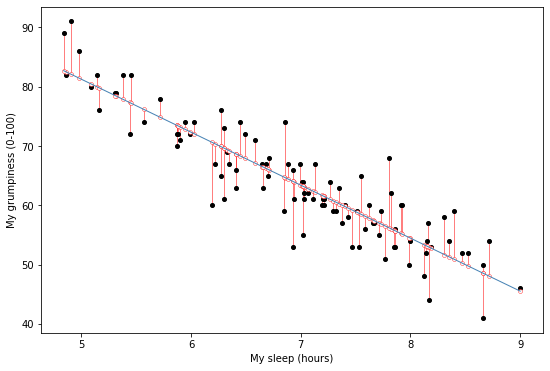

In [33]:
# load in the sleep/grump data, fit the regression, and plot the best fitting line and the residuals
parenthood_df = pd.read_csv('http://gureckislab.org/courses/fall19/labincp/data/parenthood.csv', sep = ',', header='infer')
parenthood_df.columns=['sleep','babysleep','grump','day']

lr = smf.ols(formula="grump ~ sleep", data=parenthood_df)
fit = lr.fit() # fit
params, pred, resid = fit.params, fit.fittedvalues, fit.resid
#display(fit.summary())

fig, ax = plt.subplots(figsize=(9,6))

x1 = np.linspace(parenthood_df.sleep.min(), parenthood_df.sleep.max(),400)
y1 = params['sleep']*x1+params['Intercept']

ax.plot(parenthood_df.sleep, parenthood_df.grump,'ko',markersize=4)
ax.plot(parenthood_df.sleep, parenthood_df.grump-resid,'o',markersize=4,markeredgecolor='r', markeredgewidth=.4, markerfacecolor='white')

ax.plot(x1,y1,'-',color='steelblue',linewidth=1)

ax.vlines(parenthood_df.sleep, parenthood_df.grump, parenthood_df.grump-resid,'r',linewidth=0.5)

plt.xlabel("My sleep (hours)")
plt.ylabel("My grumpiness (0-100)")
plt.show()

The figure shows a depiction of the residuals associated with the best fitting regression line through the sleepy and grumpy data.

More specifically this is the best fitting line because it minimizes the summed squared distance of each point to the line $\mbox{SS}_{res} = \sum_i (Y_i - \hat{Y}_i)^2$

### Applying our regression knowledge to fMRI data

For MRI data what we would like to explain is the fluctuation in the signal level over time for each voxel to help us understand how the brain is related to behavior. For example, if we see that a part of the brain has fMRI signal that is correlated with our "expected response" timecourse that we plotted above, we might infer that this part of the brain is involved in processing speech or auditory stimuli. 

So whereas previously we were interested in whether the amount of sleep (the values in $X$, scaled by the best fitting $b_1$ parameter and with an intercept specified by $b_0$) could account for the variation in grumpiness over time, now we're going to see whether there are any voxels whose activation is related to a scaled and/or shifted version of our expected response.

In terms of the equation above, each voxel has a timeseries of activation $Y$ that we would like to understand. For each voxel we will find a $b_1$ and $b_0$ that when combined with the expected response in $X$ produces the closest match to the voxel's timecourse. 

There is no guarantee that the *best fit* line for a particular voxel is actually a ***good*** fit, so we will further explore which voxels have signal are well accounted for by our expected response model by (1) examining the magnitude and sign (positive or negative) of the estimated $b$ which tells us how much a change in our predictor ($X$) causes a change in our outcome ($Y$); and (2) the ratio of the $\mbox{SS}_{res}$ to the $\mbox{SS}_{tot}$ which tells us if $(b_1 \cdot $X$)+b_0$ fits the actual activation timecourse very well (see above).

Let's start by taking a look at different ways of modifying our predicted response.

In the sleepy and grumpy data we ordered the data according to magnitude, giving ***monotonic*** a line. Our predicted response in the MRI data looks a little different: it is sorted by time and the magnitude goes up and down over time.

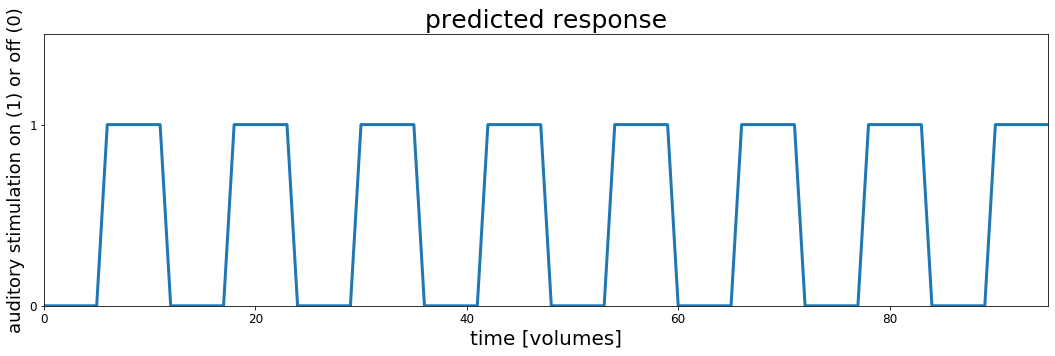

In [34]:
# Plot the predictor timecourse of auditory stimulation
fig, ax = plt.subplots(1, 1, figsize=[18, 5])

ax.plot(predicted_response, lw=3)
ax.set_xlim(0, acq_num-1)
ax.set_ylim(0, 1.5)
ax.set_title('predicted response', fontsize=25)
ax.set_yticks([0,1])
ax.set_xlabel('time [volumes]', fontsize=20)
ax.set_ylabel('auditory stimulation on (1) or off (0)', fontsize=18)
ax.tick_params(labelsize=12)
ax.tick_params(labelsize=12)

# fig.subplots_adjust(wspace=0, hspace=0.5)
plt.show()

So although this predicted response doesn't have the classic y = mx + b form of a line like you might expect, the logic of what we're doing is the same: we will look for a $B_1$ value by which we multiply each value in the predictor timecourse and a $B_0$ value which we will add as the intercept.

The next cell will give you a feel for what the regression is doing. Using the slider you can adjust the $b_1$ value that scales the predictor response:

$$
\hat{Y_i} = b_1 X_i + b_0
$$

For each setting of $b_1$ we multiply $b_1$ times every value in the predictor timecourse.

The goal of the regression is to find the setting of $b_1$ that minimizes the sum of the difference between each point in the voxel timeseries and the corresponding point in the predictor time series. The best $b_1$ value is the one that minimizes the summed lengths of the red lines in the next plot.

In [35]:
@widgets.interact(b_1=widgets.FloatSlider(min=0, max=5, step=.1, value=.1))
def plot_glm_resids(b_1):
    # set the intercept to zero for now
    b_0 = 0
    #setup the figure:
    fig, ax = plt.subplots(1, 1, figsize=[18, 5])

    # make the predicted response for particular b_1 setting
    scaled_predicted_reponse = (b_1*predicted_response) + b_0
    x_coord = 32 
    y_coord = 11
    z_coord = 34
    resid = scale(functional_data[x_coord, y_coord, z_coord,:])-scaled_predicted_reponse
        
    ax.plot(scale(functional_data[x_coord,  y_coord, z_coord,:])-resid,'o',markersize=4,markeredgecolor='r', markeredgewidth=.4, markerfacecolor='white')
    ax.plot(scale(functional_data[x_coord, y_coord, z_coord,:]),'ko',markersize=4)
    ax.plot(scale(functional_data[x_coord, y_coord, z_coord,:]),label='voxel timecourse')
    ax.plot(scaled_predicted_reponse, label='predictor response scaled by b_1', color='black')

    ax.vlines(range(0,96),scale(functional_data[x_coord, y_coord, z_coord,:]), scale(functional_data[x_coord, y_coord, z_coord,:])-resid,'r',linewidth=0.5)
    # set the intercept term to zero for now
    plt.legend()
    plt.title('voxel timecourse and residuals for best fitting line with b_1=' + str(b_1))
    plt.show()    

interactive(children=(FloatSlider(value=0.1, description='b_1', max=5.0), Output()), _dom_classes=('widget-int…

Now do that for the other 200000 voxels in the brain.

Actually let's have the computer do it for us.

The next cell defines a regression function that takes in our $X$ variable containing the predictor timecourses and the Y variable containing the output data we would like to predict.

In sleep/grump the sleep is the $X$ and grumpiness is $Y$.

For the fMRI data the $X$ will contain the timecourse of auditory stimulation (and a constant term -- check the Regression chapter for more details).

The regression function will give back the following variables:

- beta: two values for each voxel specifying the best fitting values for $b_1$ and $b_0$

- model: the best fitting line (timeseries) for this voxel (this corresponds to the black line in the figure above)

- e: the error, or residuals, that remain when we substract the best fitting line from the actual data

- r: the ratio between the residual variance and the total variance for each voxel timeseries

If you're interested in the calculation and/or have some background in linear algebra take a look at the ordinary least squares formula in the Regression chapter and the way that we build up the tmp variables in the do_brain_regression function.

In [36]:
def do_brain_regression(X, y):
    
    # Make sure design matrix has the right orientation
    if X.shape[1] > X.shape[0]:
        X = X.transpose()
    
    # Calculate the dot product of the transposed design matrix and the design matrix
    # and invert the resulting matrix.
    tmp   = np.linalg.inv(X.transpose().dot(X))
    
    # Now calculate the dot product of the above result and the transposed design matrix
    tmp   = tmp.dot(X.transpose())

    # Pre-allocate variables
    beta  = np.zeros((y.shape[0], X.shape[1]))
    e     = np.zeros(y.shape)
    model = np.zeros(y.shape)
    r     = np.zeros(y.shape[0])
    
    # Find beta values for each voxel and calculate the model, error and the correlation coefficients 
    for i in range(y.shape[0]):
        beta[i]  = tmp.dot(y[i,:].transpose())
        model[i] = X.dot(beta[i])
        e[i]     = (y[i,:] - model[i])
        r[i]     = np.sqrt(model[i].var()/y[i,:].var())
    
    return beta, model, e, r


For regression we need a "design matrix". This is simply a 2d array that contains the predictors that we will use to try to explain the observed data. One dimension of the array corresponds to each predictor and the other is the timepoints.

For the current example this will contain only the constant term and the auditory predictor timecourse, but one of the great strengths of regression is the ability to simultaneously test the explanatory effect of multiple predictor variables (see Regression chapter for more details).

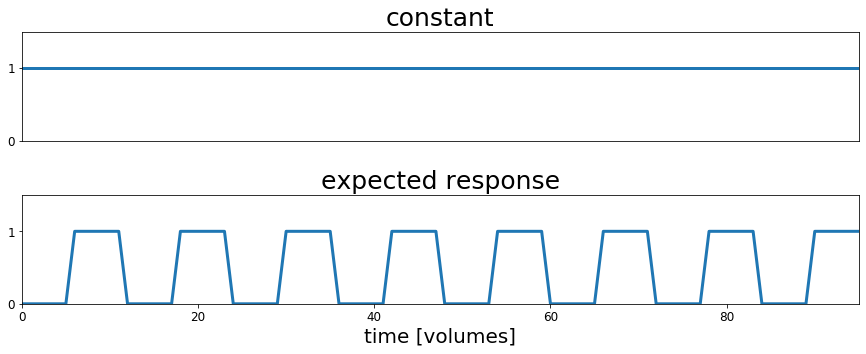

In [37]:
# Create the design matrix
constant = np.ones(acq_num)
rest     = np.zeros(block_size)
stim     = np.ones(block_size)
block    = np.concatenate((rest, stim), axis=0)
predicted_response = np.tile(block, int(block_total/2))

design_matrix = np.array((constant, predicted_response))


# Create the plots
fig, ax = plt.subplots(2,1, figsize=(15, 5))
ax[0].plot(design_matrix[0], lw=3)
ax[0].set_xlim(0, acq_num-1)
ax[0].set_ylim(0, 1.5)
ax[0].set_title('constant', fontsize=25)
ax[0].set_xticks([])
ax[0].set_yticks([0,1])
ax[0].tick_params(labelsize=12)
ax[0].tick_params(labelsize=12)

ax[1].plot(design_matrix[1], lw=3)
ax[1].set_xlim(0, acq_num-1)
ax[1].set_ylim(0, 1.5)
ax[1].set_title('expected response', fontsize=25)
ax[1].set_yticks([0,1])
ax[1].set_xlabel('time [volumes]', fontsize=20)
ax[1].tick_params(labelsize=12)
ax[1].tick_params(labelsize=12)

fig.subplots_adjust(wspace=0, hspace=0.5)
plt.show()

Now we're ready to conduct a regression analysis for each voxel in the brain, finding the best fitting $b_1$ and $b_0$ values so that we can minimize the difference between each true voxel timeseries $Y$ and the predicted timeseries constructed as 
$$
\hat{Y_i} = b_1 X_i + b_0
$$


In [38]:
# run the regression model for each voxel
beta, model, e, r = do_brain_regression(design_matrix, all_data_2d)

In [39]:
# reshape the outputs for visualization
r_glm_vol = np.reshape(r, (nx, ny, nz))
b_1 = beta[:,1]
b_1 = np.reshape(b_1, (nx, ny, nz))

b_0 = beta[:,0]
b_0 = np.reshape(b_0, (nx, ny, nz))

The regression analysis gives us the $b_1$ value that tells us how much to scale the predictor reponse in order to best match the voxel timecourse. Higher values of $b_1$ mean that for every change in the predictor timecourse there is a change in the voxel timecourse.

Let's see which voxels were best explained by this regression analysis.

In [41]:
# PLOT THE REGRESSION RESULTS
b_1_thresh = 30
b_1_thresholded = b_1.copy()
b_1_thresholded[b_1_thresholded < b_1_thresh]=np.nan
# # p_thresholded[p_thresholded > p_val_cutoff] = np.nan

@widgets.interact(slice=widgets.IntSlider(min=0, max=53, step=1, value=0))
def plot_glm_results(slice):
    fig, ax = plt.subplots(1, 1, figsize=[10,10])
    ax.imshow(functional_data[:,:,slice,10], cmap='gray')
    ax.imshow(b_1_thresholded[:,:,slice], cmap='afmhot')
    ax.set_title('thresholded map (b_1 > ' + str(b_1_thresh) + ')', fontsize=25)
    fig.subplots_adjust(wspace=0, hspace=0)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

interactive(children=(IntSlider(value=0, description='slice', max=53), Output()), _dom_classes=('widget-intera…

We can also look through the regression results to find the voxel that was best fit by our analysis kind of like we did with the correlation analysis earlier in this notebook.

This time we will plot the voxel timecourse and the $\hat{Y}$ timecourse obtained by ($b_1$*predictor_timecourse)$+b_0$

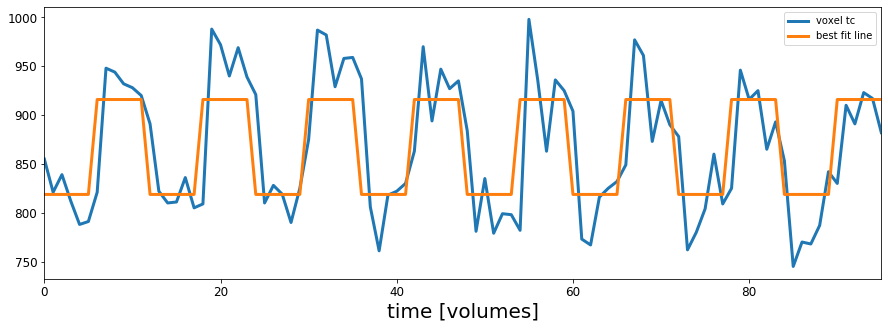

In [42]:
max_idx = r_glm_vol.argmax()
# argmax returns the linear index, so turn into x/y/z index values
max_x, max_y, max_z = np.unravel_index(max_idx, r_glm_vol.shape)

# use the max_x, _y, and _z indices to get the timecourse of the best correlated voxel
max_corr_timecourse = functional_data[max_x, max_y,max_z,:]

# use the b_1 and b_0 values for this voxel to compute the best fitting line
y_hat = (b_1[max_x, max_y, max_z]*predicted_response) + b_0[max_x, max_y, max_z]


# Create the plots
fig, ax = plt.subplots(1,1,figsize=(15, 5))
ax.plot(max_corr_timecourse, lw=3, label='voxel tc')
ax.plot(y_hat, lw=3, label='best fit line')
ax.set_xlim(0, acq_num-1)
ax.set_xlabel('time [volumes]', fontsize=20)
ax.tick_params(labelsize=12)
ax.legend()
plt.show()

Not bad. It looks like this voxel has a timeseries of BOLD activation that tracks pretty well with our timecourse of auditory stimulation scaled by $b_1$ and with an intercept of $b_0$. It doesn't look perfect, but that's OK, it would be pretty surprising if we could explain *everything* that the brain is doing throughout the course of an experiment and besides, I guarantee you cannot find a better fit for this voxel than what is shown here.

<div class="alert alert-info" role="alert">
  <strong>Question 10</strong> <br>
    Take a look through the slices showing the results of our regression analysis in the cell titled # PLOT THE REGRESSION RESULTS. In particular, look around slices 35 and 36. How do these results compare to the version we did using correlation? Given what you've learned about correlation and regression, should we expect these results to look similar or different and why?
</div>

<div class="alert alert-warning" role="alert">
  <strong>Your Answer</strong> <br>
  Delete this text and put your answer here.
</div>